En primer lugar, descargamos los datos que usaremos para entrenar la red neuronal.

In [1]:
# CELDA 1: CARGA DE DATOS
# ======================
# Importamos las librerías necesarias
from sklearn.datasets import fetch_openml  # Para descargar el dataset MNIST
import numpy as np  # Para operaciones numéricas

# MNIST es un dataset clásico de ML: 70,000 imágenes de dígitos escritos a mano (0-9)
# Cada imagen es de 28x28 píxeles = 784 valores
mnist = fetch_openml('mnist_784', version=1)

# Separamos features (X) y labels (y)
# X: matriz de 70,000 filas x 784 columnas (cada fila es una imagen aplanada)
# y: vector de 70,000 elementos con los dígitos correspondientes (0-9)
X, y = mnist["data"].values.astype(np.float32), mnist["target"].values.astype(int)

Vamos a visualizar algunos ejemplos de los datos que acabamos de descargar.

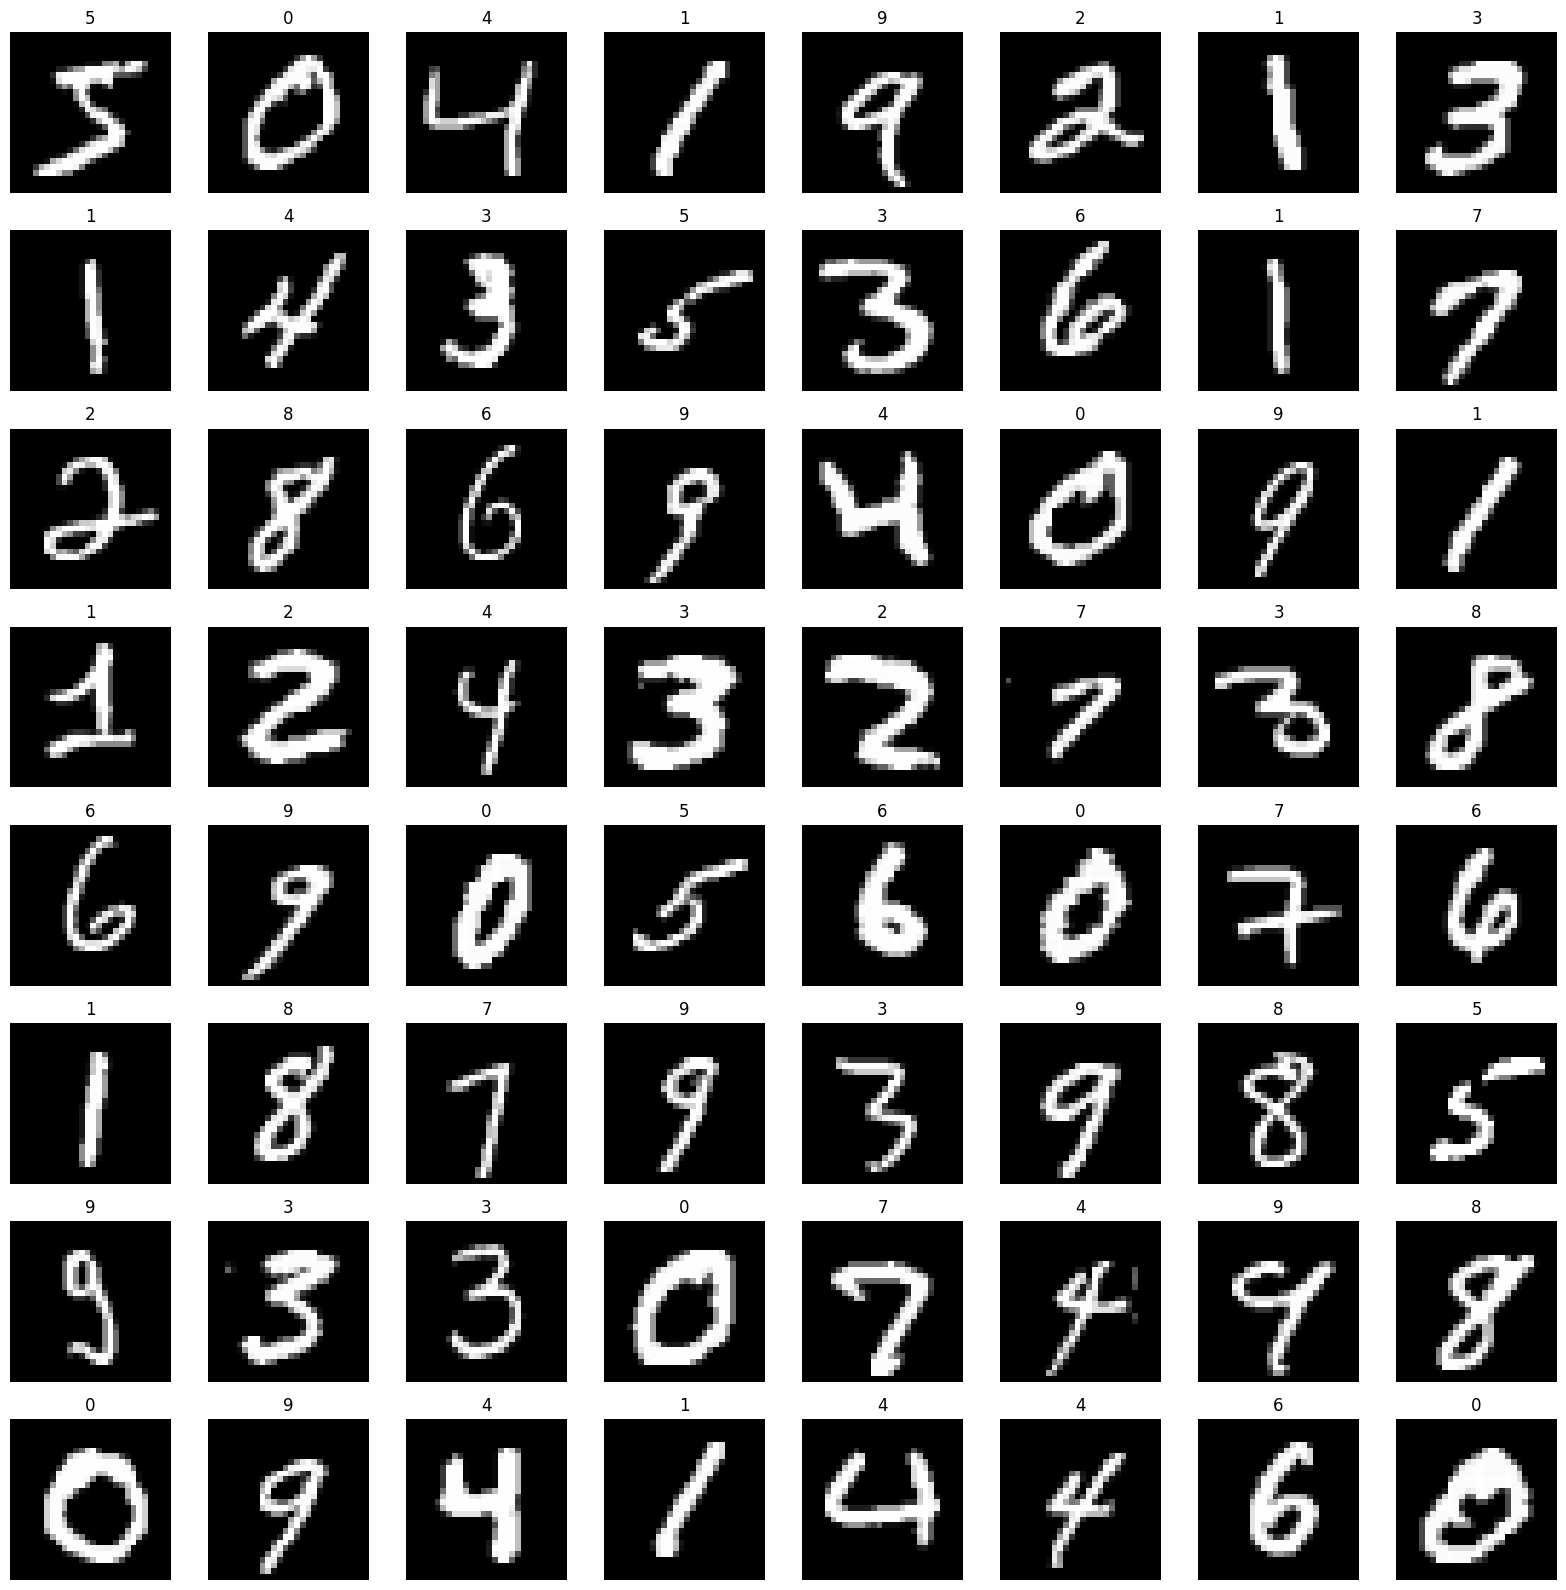

In [2]:
# CELDA 2: VISUALIZACIÓN DE DATOS
# ================================
import matplotlib.pyplot as plt

# Creamos una cuadrícula de 8x8 para visualizar 64 ejemplos
r, c = 8, 8  # r = filas, c = columnas
fig = plt.figure(figsize=(2*c, 2*r))  # Tamaño de la figura

# Recorremos cada posición de la cuadrícula
for _r in range(r):
    for _c in range(c):
        ix = _r*c + _c  # Índice de la imagen en el dataset
        ax = plt.subplot(r, c, ix + 1)  # Creamos un subplot
        ax.axis("off")  # Ocultamos los ejes
        
        # Reshape de 784 valores a matriz 28x28 para visualizar como imagen
        ax.imshow(X[ix].reshape(28,28), cmap="gray")
        
        # Título = etiqueta verdadera (el dígito que representa)
        ax.set_title(y[ix])
        
plt.tight_layout()  # Ajusta el espaciado entre subplots
plt.show()

Cada imagen tiene asociada su etiqueta, que indica el número que representa, y que es lo que queremos que nuestra red neuronal aprenda a predecir dada una imagen de entrada.

![](https://miro.medium.com/v2/resize:fit:679/0*u5-PcKYVfUE5s2by.gif)

Vamos a usar una red neuronal sencilla, conocida como perceptrón multicapa, que consiste en una serie de capas de neuronas conectadas entre sí. Cada neurona recibe como entrada las salidas de las neuronas de la capa anterior, y produce una salida que es la entrada de las neuronas de la capa siguiente.

In [3]:
# CELDA 3: DEFINICIÓN DEL MODELO (RED NEURONAL)
# ==============================================
from torch.nn import Sequential as S  # Contenedor para apilar capas
from torch.nn import Linear as L      # Capa densa (fully connected)
from torch.nn import ReLU as R        # Función de activación

# ARQUITECTURA DEL MODELO: Perceptrón Multicapa (MLP)
# ====================================================
model = S(
    L(784, 128),  # Capa 1: 784 neuronas de entrada → 128 neuronas ocultas
                  # (784 = 28x28 píxeles de cada imagen aplanada)
    
    R(),          # Función de activación ReLU: f(x) = max(0, x)
                  # Introduce no-linealidad para aprender patrones complejos
    
    L(128, 10)    # Capa 2: 128 neuronas ocultas → 10 neuronas de salida
                  # (10 = número de clases: dígitos del 0 al 9)
)

# Visualizamos la arquitectura del modelo
model

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
# CELDA 4: DEFINICIÓN DEL MODELO (RED NEURONAL)
# ==============================================
from torch.nn import Sequential as S  # Contenedor para apilar capas
from torch.nn import Linear as L      # Capa densa (fully connected)
from torch.nn import ReLU as R        # Función de activación

# ARQUITECTURA DEL MODELO: Perceptrón Multicapa (MLP) PROFUNDO
# =============================================================
model = S(
    L(784, 128),  # Capa 1: 784 neuronas de entrada → 128 neuronas ocultas
                  # (784 = 28x28 píxeles de cada imagen aplanada)
    
    R(),          # Función de activación ReLU: f(x) = max(0, x)
                  # Introduce no-linealidad para aprender patrones complejos
    
    L(128, 64),   # Capa 2: 128 → 64 neuronas ocultas
                  # Reduce dimensionalidad progresivamente
    
    R(),          # Activación ReLU para la segunda capa oculta
    
    L(64, 32),    # Capa 3: 64 → 32 neuronas ocultas
                  # Continúa extrayendo características de alto nivel
    
    R(),          # Activación ReLU para la tercera capa oculta
    
    L(32, 10)     # Capa 4 (salida): 32 neuronas ocultas → 10 neuronas de salida
                  # (10 = número de clases: dígitos del 0 al 9)
)

# Visualizamos la arquitectura del modelo
model

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=32, bias=True)
  (5): ReLU()
  (6): Linear(in_features=32, out_features=10, bias=True)
)

In [5]:
# CELDA 5: DEFINICIÓN DEL MODELO (RED NEURONAL) expasion dimensional
# ==============================================
from torch.nn import Sequential as S  # Contenedor para apilar capas
from torch.nn import Linear as L      # Capa densa (fully connected)
from torch.nn import ReLU as R        # Función de activación

# ARQUITECTURA DEL MODELO: Perceptrón Multicapa (MLP) CON EXPANSIÓN
# ==================================================================
model = S(
    L(784, 128),  # Capa 1: 784 neuronas de entrada → 128 neuronas ocultas
                  # (784 = 28x28 píxeles de cada imagen aplanada)
    
    R(),          # Función de activación ReLU: f(x) = max(0, x)
                  # Introduce no-linealidad para aprender patrones complejos
    
    L(128, 256),  # Capa 2: 128 → 256 neuronas ocultas
                  # EXPANDE la dimensionalidad para capturar más características
    
    R(),          # Activación ReLU para la segunda capa oculta
    
    L(256, 512),  # Capa 3: 256 → 512 neuronas ocultas
                  # Continúa expandiendo el espacio de representación
    
    R(),          # Activación ReLU para la tercera capa oculta
    
    L(512, 10)    # Capa 4 (salida): 512 neuronas ocultas → 10 neuronas de salida
                  # (10 = número de clases: dígitos del 0 al 9)
)

# Visualizamos la arquitectura del modelo
model

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=512, bias=True)
  (5): ReLU()
  (6): Linear(in_features=512, out_features=10, bias=True)
)

In [ ]:
''' 
32

64

128

256

512

''' 

Dado un conjunto de imágenes de entrada, la red neuronal produce una salida para cada una de ellas, que es la predicción que hace la red neuronal sobre la etiqueta de la imagen.

In [4]:
# CELDA 4: PREDICCIONES SIN ENTRENAR (ALEATORIAS)
# ================================================
import torch 

# Tomamos las primeras 10 imágenes y las pasamos por la red
y_hat = model(torch.tensor(X[:10]))  # y_hat tiene shape (10, 10)
                                      # 10 muestras x 10 probabilidades (una por clase)

# argmax extrae el índice de la probabilidad más alta = predicción
preds = torch.argmax(y_hat, dim=1)  # dim=1 significa "por fila"

# Mostramos las predicciones
preds  # Serán aleatorias porque el modelo aún NO está entrenado

tensor([4, 3, 3, 3, 3, 3, 3, 3, 3, 3])

Como la red aún no está entrenada, las predicciones que hace son aleatorias. El siguiente bloque de código se encarga de entrenar la red.

In [5]:
# CELDA 5: ENTRENAMIENTO DEL MODELO
# ==================================
from tqdm import tqdm  # Para mostrar barras de progreso

# PREPARACIÓN DE LOS DATOS
# -------------------------
# Dividimos en train (primeros 60k) y test (últimos 10k)
X_train, X_test = torch.from_numpy(X[:60000] / 255.), torch.from_numpy(X[60000:] / 255.)
# Dividimos por 255 para normalizar los píxeles de [0, 255] a [0, 1]

y_train, y_test = torch.from_numpy(y[:60000]), torch.from_numpy(y[60000:])

# HIPERPARÁMETROS
# ----------------
bs = 32  # Batch size: procesamos 32 imágenes a la vez (más eficiente)
num_batches = len(X_train) // bs  # Número total de batches por época

# FUNCIÓN DE PÉRDIDA Y OPTIMIZADOR
# ---------------------------------
loss_fn = torch.nn.CrossEntropyLoss()  # Función de pérdida para clasificación
                                        # Combina Softmax + Negative Log Likelihood
                                        
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  # Optimizador Adam
                                                           # lr = learning rate (tasa de aprendizaje)

# BUCLE DE ENTRENAMIENTO
# -----------------------
for epoch in range(10):  # 10 épocas = 10 pasadas completas por el dataset
    
    for b in tqdm(range(num_batches)):  # Iteramos por cada batch
        # Extraemos un batch de datos
        x = X_train[b*bs:(b+1)*bs]  # 32 imágenes
        y = y_train[b*bs:(b+1)*bs]  # 32 etiquetas
        
        # FORWARD PASS: predicciones del modelo
        y_hat = model(x)
        
        # Calculamos la pérdida (error) entre predicciones y etiquetas reales
        loss = loss_fn(y_hat, y)
        
        # BACKWARD PASS: calculamos gradientes
        optimizer.zero_grad()  # Limpiamos gradientes anteriores
        loss.backward()        # Calculamos nuevos gradientes (backpropagation)
        optimizer.step()       # Actualizamos los pesos del modelo
        
    # Mostramos la pérdida al final de cada época
    print(f"Epoch {epoch+1} loss: {loss.item():.3f}")

100%|██████████| 1875/1875 [00:03<00:00, 494.49it/s]


Epoch 1 loss: 0.043


100%|██████████| 1875/1875 [00:04<00:00, 385.64it/s]


Epoch 2 loss: 0.031


100%|██████████| 1875/1875 [00:04<00:00, 440.45it/s]


Epoch 3 loss: 0.036


100%|██████████| 1875/1875 [00:04<00:00, 439.45it/s]


Epoch 4 loss: 0.027


100%|██████████| 1875/1875 [00:04<00:00, 431.99it/s]


Epoch 5 loss: 0.017


100%|██████████| 1875/1875 [00:04<00:00, 410.32it/s]


Epoch 6 loss: 0.006


100%|██████████| 1875/1875 [00:04<00:00, 398.48it/s]


Epoch 7 loss: 0.004


100%|██████████| 1875/1875 [00:04<00:00, 378.57it/s]


Epoch 8 loss: 0.008


100%|██████████| 1875/1875 [00:04<00:00, 438.77it/s]


Epoch 9 loss: 0.002


100%|██████████| 1875/1875 [00:04<00:00, 385.02it/s]

Epoch 10 loss: 0.001


Una vez entrenada la red, podemos evaluar su rendimiento sobre los datos de test.

In [6]:
# CELDA 6: EVALUACIÓN EN TEST
# ============================
acc = 0  # Contador de aciertos

# torch.no_grad() desactiva el cálculo de gradientes (no necesitamos entrenar)
# Esto ahorra memoria y acelera la inferencia
with torch.no_grad():
    for b in range(num_batches):
        # Extraemos un batch del conjunto de test
        x = X_test[b*bs:(b+1)*bs]
        y = y_test[b*bs:(b+1)*bs]
        
        # Hacemos predicciones
        y_hat = model(x)
        
        # Comparamos predicciones con etiquetas reales
        # torch.argmax convierte probabilidades en clase predicha
        acc += torch.sum(torch.argmax(y_hat, dim=1) == y).item()

# Mostramos accuracy = aciertos / total
print(f"Accuracy: {acc} / {len(X_test)}")

Accuracy: 9761 / 10000


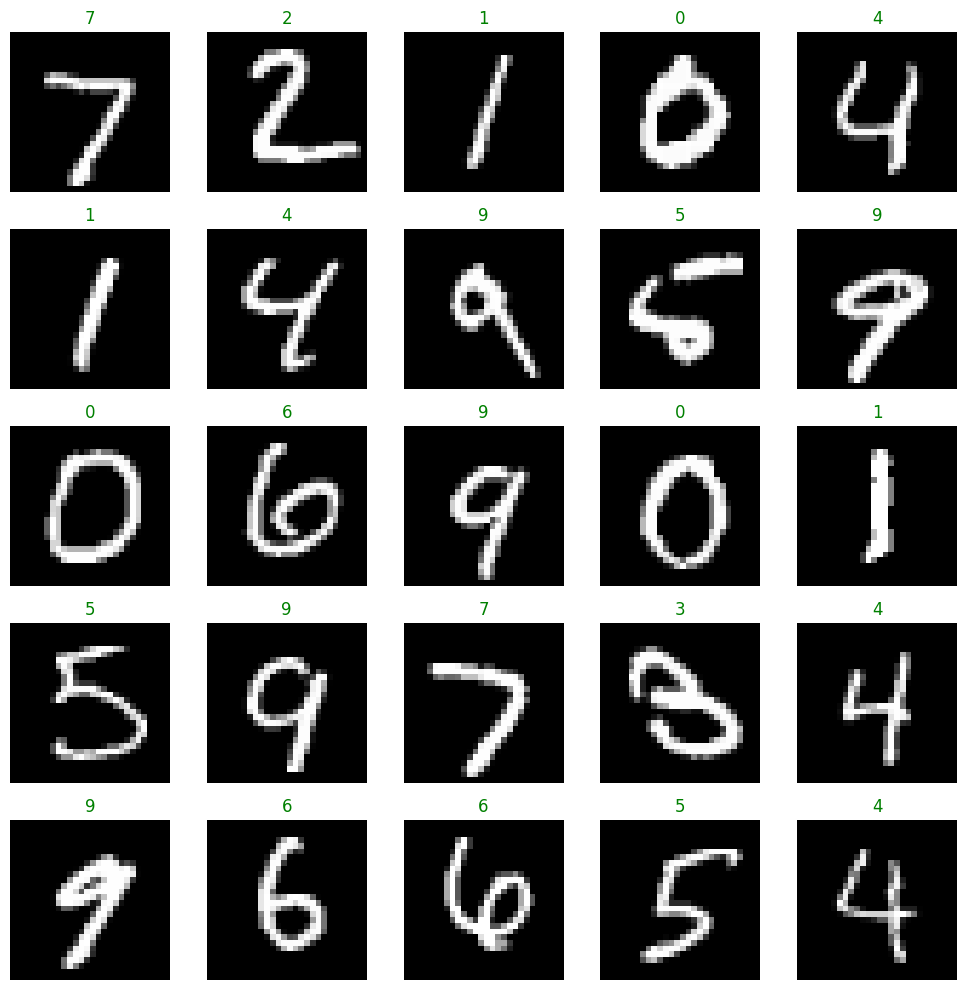

In [7]:
# CELDA 7: VISUALIZACIÓN DE RESULTADOS
# =====================================
r, c = 5, 5  # Cuadrícula de 5x5 = 25 ejemplos
fig = plt.figure(figsize=(2*c, 2*r))

for _r in range(r):
    for _c in range(c):
        ix = _r*c + _c
        ax = plt.subplot(r, c, ix + 1)
        ax.axis("off")
        
        # Hacemos predicción para una imagen del test
        pred = torch.argmax(model(X_test[ix]).unsqueeze(0)).item()
        # unsqueeze(0) añade dimensión de batch (modelo espera batches)
        
        # Mostramos la imagen
        ax.imshow(X_test[ix].reshape(28,28), cmap="gray")
        
        # Título = predicción
        # Color VERDE si es correcta, ROJO si es incorrecta
        ax.set_title(pred, color="green" if pred == y_test[ix] else "red")
        
plt.tight_layout()
plt.show()

Nuestra red es capaz de predecir correctamente el 98% de las imágenes de test. ¡Felicidades! Has entrenado tu primera red neuronal.